In [1]:
import importlib
import sys
import glob
sys.path.append("../")
import help_functions as hf
importlib.reload(hf)
from help_functions import *
from data_modules.visum10x import Visum10xDataModule
#============ Output dirs =======================
fig_dir = "figures/app5///"
file_dir = "processed_data/app5_slide-seq/"
exp_dir = "../exper/app5_rodriques_slideseq///"
mpl.rcParams['axes.linewidth'] = 0.75

1.0
1.0


# Load data

In [37]:
from data_modules.dataset import SpatialDataModule
ann_data = sc.read_h5ad("../../datasets/rodriques_slideseq.h5ad")
print(ann_data)
data_module = SpatialDataModule()
ann_data.X = ann_data.X.toarray()
data_module.ann_data = ann_data
data_module.prepare_data(rad_cutoff=40, n_top_genes=3000, min_counts=20)
ann_data = copy.copy(data_module.ann_data)

AnnData object with n_obs × n_vars = 32701 × 6942
    obsm: 'spatial'
After filtering:  (25641, 6942)
------Calculating spatial graph...
The graph contains 237172 edges, 25641 cells.
9.2497 neighbors per cell on average.


In [38]:
version_dirs = glob.glob(os.path.join(exp_dir, "version_*"))
version_dirs = sorted(version_dirs, key=lambda x: int(x.split("_")[-1]))[:20]
print(version_dirs[-1])

../exper/app5_rodriques_slideseq/version_19


# Visualize spatial domains

In [39]:
ann_data = copy.copy(data_module.ann_data)
consensus_labels = np.load("../exper/app5_rodriques_slideseq/consensus5.npy")
ann_data.obs["Consensus clustering"] = consensus_labels.astype(str)
n_class = np.max(consensus_labels) + 1
print("n_class", n_class)

n_class 5


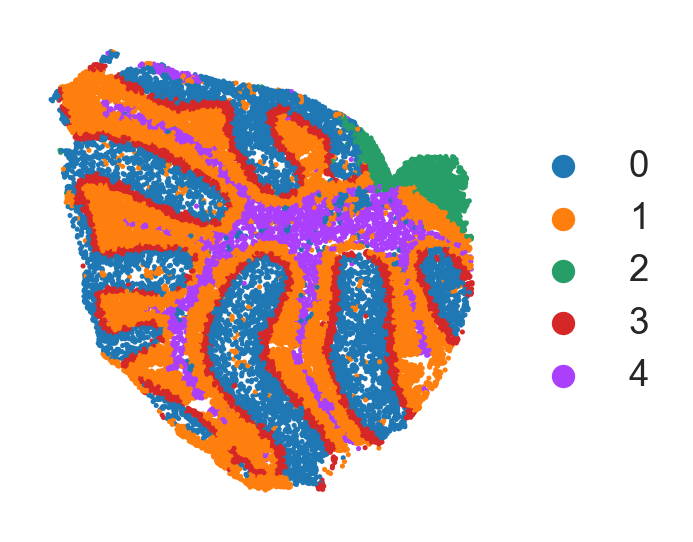

In [5]:
a = 1.5
fig, ax = plt.subplots(1, 1, figsize=(1.45 * a, 1.42 * a))
sc.pl.embedding(ann_data, basis="spatial", color = "Consensus clustering", show=False, ax=ax, s=6, 
                 palette=vega_20_scanpy, frameon=False)
ax.set_title("")
ax.set_aspect("equal")
plt.savefig(os.path.join(fig_dir, "consensus_domain.png"), dpi=300)

In [6]:
smaps_mean, recons_mean = compute_smaps_mean(data_module, version_dirs)
zsmap = compute_smap_zscore(smaps_mean, ann_data.obs["Consensus clustering"], logtransform=True)

In [7]:
saliency_scores_df = pd.DataFrame(index=ann_data.var.index)
for ind in range(n_class):
    saliency_scores_df[f"score_{ind}"] = np.linalg.norm(smaps_mean[ann_data.obs["Consensus clustering"] == str(ind), :], axis=0)
saliency_scores_df.to_csv(os.path.join(file_dir, "STAMarker_SVGs.csv"))

# Upsetplot

508


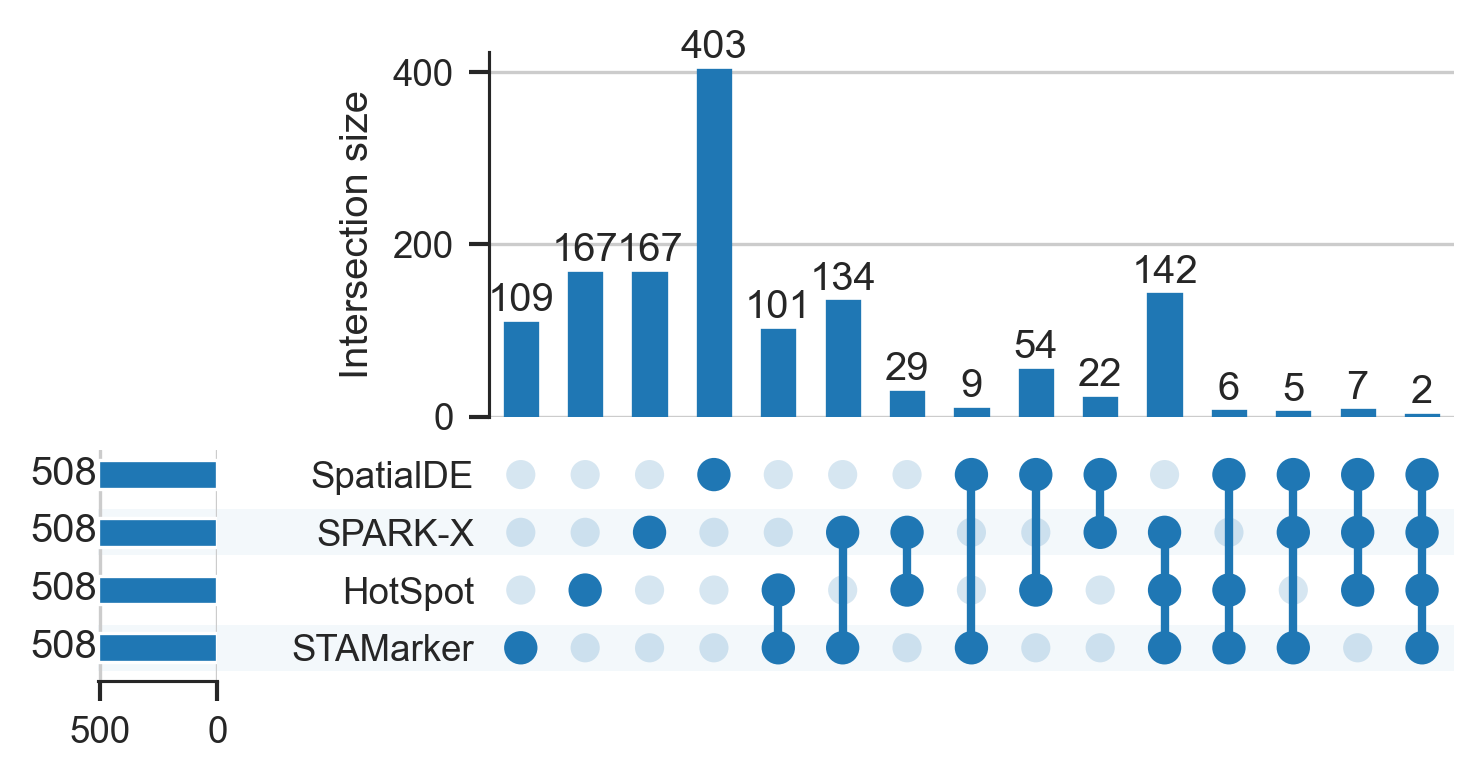

In [8]:
genes_all, stmarker_svgs_list = load_SVGs(file_dir, n_class, alpha=1.5)
fig, upset_df_methods = plot_upset_plot(genes_all, file_dir, fig_dir, figsize=(3.2, 1.85))
print(len(genes_all["STAMarker"]))
upset_df_methods = from_contents(genes_all)
upset_df_methods.to_csv(os.path.join(file_dir, "upset_methods.csv"))

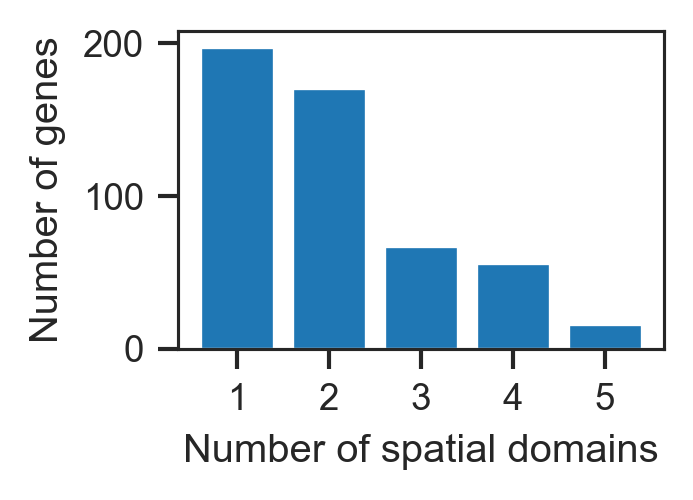

In [9]:
fig, upset_domains_df = plot_module_bar(stmarker_svgs_list, file_dir, fig_dir, figsize=(2.4, 1.75))

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

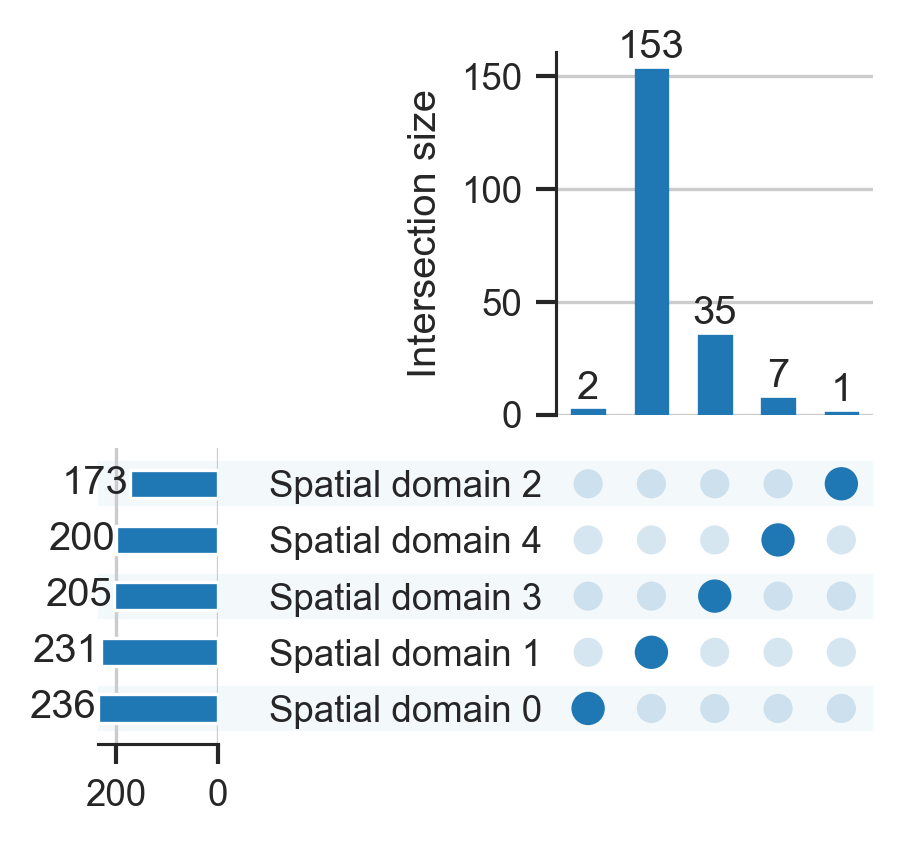

In [10]:
fig = plt.figure(figsize=(3.2, 1.9))
plot(upset_domains_df, sort_by="degree", fig=fig, 
     facecolor=vega_10_scanpy[0], show_counts=True, element_size=20, max_degree=1)

In [11]:
morans_i_array = compute_morans_I(ann_data, data_module, version_dirs)
stmarker_domains_df = get_svg_domains_df(ann_data, upset_domains_df, morans_i_array)
stmarker_domains_df["Specific"] = np.isin(stmarker_domains_df.index, upset_df_methods.loc[(True, False, False, False)])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Plot gene modules

In [349]:
df = stmarker_domains_df[stmarker_domains_df.n_domains <= 2]
gene_indices = find_indices(ann_data, df.index.tolist())
print(len(gene_indices))
cov_dict = get_cov_mat(gene_indices, ann_data.X, recons_mean, np.log(smaps_mean + 1), 
                       save_path="../exper/app4_mouse_stero_embryo///smaps_stmarker.mat")

369


In [54]:
consesus_clustering_R(cov_dict["smaps"], 5, "app5")

R[write to console]: end fraction

R[write to console]: clustered

R[write to console]: clustered

R[write to console]: clustered

R[write to console]: clustered



In [57]:
from sklearn.decomposition import PCA
def plot_clustermap(consensus_mat, n_clusters, figsize=(3.5, 3.5), save_path=None, method="average"):
    y = pdist(consensus_mat)
    z = hierarchy.linkage(y, method=method)
    labels = hierarchy.fcluster(z, n_clusters, "maxclust")
    l, c = np.unique(labels, return_counts=True)
    print(l)
    print(c)
    row_colors = labels_to_colors(labels - 1, vega_20_scanpy)
    cg = sns.clustermap(consensus_mat, cmap="coolwarm", figsize=figsize, cbar_pos=None, 
                    row_colors=row_colors, row_linkage=z, col_linkage=z)
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    return labels

def labels_to_colors(labels, palettes):
    return [palettes[i] for i in labels]

def plot_gene_modules(ann_data, expmat, labels, genes_list, show=None, 
                      ncols=4, figsize=None, cmap="magma", used_key="spatial",
                      titles=None, vmax="p99", vmin="p1"):
    n_modules = len(np.unique(labels))
    stmarker_indices = np.array(find_indices(ann_data, genes_list).tolist())
    for module_ind in range(1, n_modules + 1):
        module_genes = stmarker_indices[labels == module_ind]
        module_exp = expmat[:, module_genes]
        print(module_exp.shape)
        pca = PCA(n_components=1)
        module_name = "Module {}".format(module_ind)
        ann_data.obs[module_name] = pca.fit(module_exp).transform(module_exp)
    nrows = max(int(np.ceil(len(show) / 1.0 / ncols)), 1)
    if figsize is None:
        figsize = (nrows * 2.5, ncols * 2.5)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    for ax_ind, module_ind in enumerate(show):
        if nrows == 1:
            ax = axs[ax_ind]
        else:
            ax = axs[ax_ind // ncols, ax_ind % ncols]
        sc.pl.embedding(ann_data, basis=used_key, color=["Module {}".format(module_ind)], 
                          s=6, show=False, vmax=vmax, vmin=vmin, ax=ax,  cmap=cmap, frameon=False)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_aspect("equal")
        if titles is not None:
            ax.set_title(titles[ax_ind])
        else:
            ax.set_title("")
    remove_cbar(fig.axes)
    plt.tight_layout()
    return fig

def consesus_clustering_R(covmat, maxK, title):
    import rpy2.robjects as ro
    from rpy2.robjects import numpy2ri
    numpy2ri.activate()
    ro.r.library("ConsensusClusterPlus")
    ConsensusClusterPlus = ro.r['ConsensusClusterPlus']
    ConsensusClusterPlus(covmat, maxK=maxK, clusterAlg = "pam", reps = 20, plot = "png", 
                                      title =title, writeTable = True)

[1 2 3 4 5]
[168 105  55  11  30]


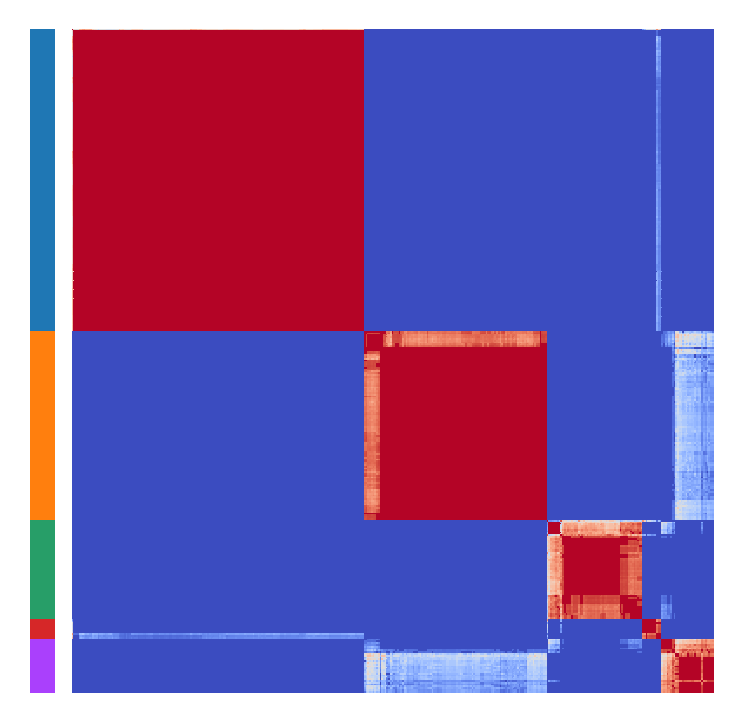

In [55]:
from scipy.cluster import hierarchy
n_modules = 5
consensus_mat_smap = pd.read_csv(f"app5/app5.k={n_modules}.consensusMatrix.csv", index_col=0)
labels_smaps = plot_clustermap(consensus_mat_smap, n_modules, save_path=os.path.join(fig_dir, f"clustermap_{n_modules}.png"))

(25641, 168)
(25641, 105)
(25641, 55)
(25641, 11)
(25641, 30)


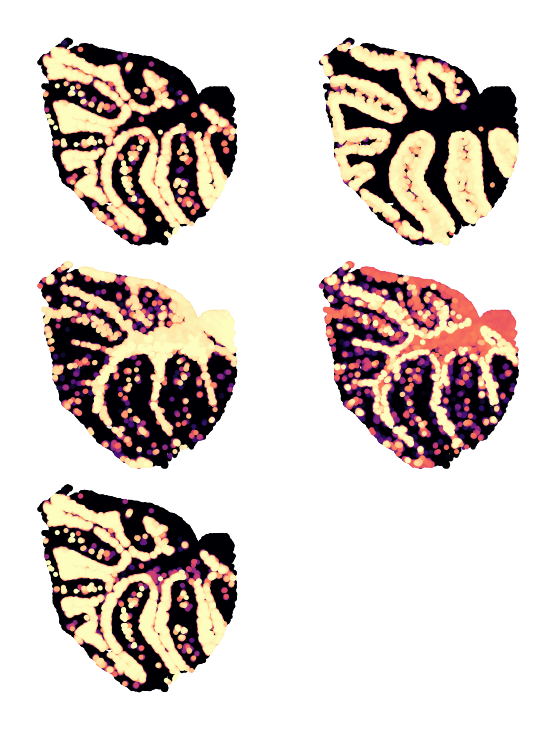

In [372]:
ann_data = copy.copy(data_module.ann_data)
fig = plot_gene_modules(ann_data, zsmap, labels_smaps, df.index.tolist(), show=[1, 2, 3, 4, 5], ncols=2,
                       figsize=(2.25, 2.75), vmax="p99", vmin=0, cmap="magma", used_key="spatial")

plt.subplots_adjust(wspace=0, hspace=0)
fig.delaxes(fig.axes[-1])
plt.savefig(os.path.join(fig_dir, "maps_modules"))

In [358]:
marker_genes = pd.read_csv("../../datasets/PanglaoDB_markers.tsv.gz", compression="gzip", delimiter="\t")
marker_genes = marker_genes[marker_genes.organ=="Brain"]
cell_types = np.unique(marker_genes["cell type"])
cerebellum_cell_types = ['Astrocytes', 'Bergmann glia',  'GABAergic neurons',
                         'Interneurons', 'Meningeal cells', 'Neuroendocrine cells',
                        'Oligodendrocytes', 
                         "Neurons",
                         'Purkinje neurons', 'Pyramidal cells', 
                         'Satellite glial cells', 'Trigeminal neurons']
cell_markers = dict()
for cell_type in cell_types:
    gene_list = marker_genes[marker_genes["cell type"] == cell_type]["official gene symbol"].tolist()
    gene_list = list(map(lambda x: x.capitalize(), gene_list))
    gene_list = all_gene_list.intersection(gene_list)
    if len(gene_list) > 0 and cell_type in cerebellum_cell_types:
        cell_markers[cell_type] = list(gene_list)
module_genes = {key: gene_indices.index[labels_smaps==key].tolist() for key in np.unique(labels_smaps)}

In [359]:
from scipy.stats import hypergeom
cell_module_df = []
for module in module_genes:
    for cell_type in cell_markers:
        inter = set(module_genes[module]).intersection(cell_markers[cell_type])
        if len(inter) > 0:
            expected = len(cell_markers[cell_type]) / 3000 * len(module_genes[module])
            observed = len(inter)
            htest = hypergeom.sf(observed, 3000, len(cell_markers[cell_type]), len(module_genes[module]))
            cell_module_df.append([module, cell_type, htest])
cell_module_df = pd.DataFrame(cell_module_df)
cell_module_df.columns = ["Module", "Cell type", "p_vals"]
cell_module_df["logp"] = - np.log(cell_module_df["p_vals"])
cell_module_rec = cell_module_df.pivot_table(index="Module", columns="Cell type", values="logp", fill_value=0)

[Text(0.5, 0, 'M1'),
 Text(1.5, 0, 'M2'),
 Text(2.5, 0, 'M3'),
 Text(3.5, 0, 'M4'),
 Text(4.5, 0, 'M5')]

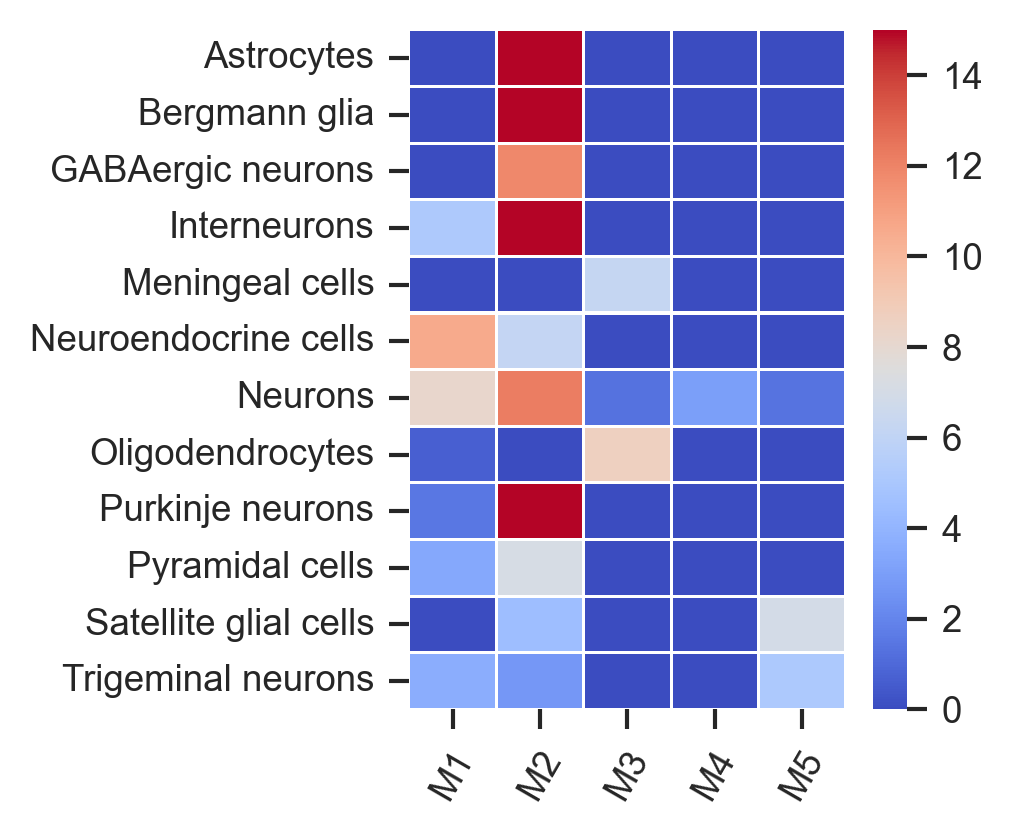

In [365]:
fig, ax = plt.subplots(1, 1, figsize=(2.35, 3))
sns.heatmap(cell_module_rec.T, ax=ax, vmax=15, vmin=0, 
            cmap="coolwarm", linewidths=0.5)
ax.set_aspect("auto")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels(["M{}".format(ind) for ind in range(1, 6)], rotation=60)

# Plot genes

In [110]:
df = stmarker_domains_df[stmarker_domains_df.n_domains <= 2]
module_df = pd.DataFrame({"module": labels_smaps.tolist()}, index=gene_indices.index)
df = pd.merge(df, module_df, left_index=True, right_index=True)
di = df[df["Spatial domain 0"]].sort_values("Morans_I", ascending=False)
di[df.Specific]

Morans_I  n_domains Spatial domain 0 Spatial domain 1  \
Icmt           0.023394        2.0             True            False   
Tuba8          0.023044        2.0             True            False   
Kcnma1         0.017879        2.0             True            False   
0610007P14Rik  0.017493        2.0             True            False   
Cep76          0.014991        2.0             True            False   
Arhgap26       0.013377        2.0             True            False   
Grm1           0.011152        2.0             True            False   
Cltc           0.010000        2.0             True            False   
Cap2           0.008564        2.0             True            False   
Prmt8          0.008414        2.0             True            False   
Mprip          0.008195        2.0             True            False   
Trove2         0.007291        2.0             True            False   
Baiap2         0.006690        2.0             True            False   
Plekhd1        0.005635        2.0             True            False   
Ubl3           0.005237        2.0             True            False   
Add3           0.004555        2.0             True            False   
Pfdn1          0.004520        2.0             True            False   
Eif3a          0.003381        2.0             True            False   
Ntsr2          0.002485        2.0             True            False   

              Spatial domain 2 Spatial domain 3 Spatial domain 4  Specific  \
Icmt                     False             True            False      True   
Tuba8                    False             True            False      True   
Kcnma1                   False             True            False      True   
0610007P14Rik            False             True            False      True   
Cep76                    False             True            False      True   
Arhgap26                 False             True            False      True   
Grm1                     False             True            False      True   
Cltc                     False             True            False      True   
Cap2                     False             True            False      True   
Prmt8                    False             True            False      True   
Mprip                    False             True            False      True   
Trove2                   False             True            False      True   
Baiap2                   False             True            False      True   
Plekhd1                  False             True            False      True   
Ubl3                     False             True            False      True   
Add3                     False             True            False      True   
Pfdn1                    False             True            False      True   
Eif3a                    False             True            False      True   
Ntsr2                    False             True            False      True   

               module  
Icmt                2  
Tuba8               2  
Kcnma1              2  
0610007P14Rik       2  
Cep76               2  
Arhgap26            2  
Grm1                2  
Cltc                1  
Cap2                2  
Prmt8               2  
Mprip               2  
Trove2              5  
Baiap2              2  
Plekhd1             2  
Ubl3                5  
Add3                5  
Pfdn1               5  
Eif3a               5  
Ntsr2               2

In [125]:
di = df[df.module==1].sort_values("Morans_I", ascending=False)
di[di.Specific]

Morans_I  n_domains Spatial domain 0 Spatial domain 1  \
Ash1l   0.011596        1.0            False             True   
St18    0.011274        1.0            False             True   
Ylpm1   0.010311        1.0            False             True   
Cltc    0.010000        2.0             True            False   
Kmt2a   0.009308        1.0            False             True   
...          ...        ...              ...              ...   
Smc1a  -0.001682        1.0            False             True   
Mllt10 -0.001826        1.0            False             True   
Pcf11  -0.001909        1.0            False             True   
Aff4   -0.002258        1.0            False             True   
Dnmt3a -0.004758        1.0            False             True   

       Spatial domain 2 Spatial domain 3 Spatial domain 4  Specific  module  
Ash1l             False            False            False      True       1  
St18              False            False            False      True       1  
Ylpm1             False            False            False      True       1  
Cltc              False             True            False      True       1  
Kmt2a             False            False            False      True       1  
...                 ...              ...              ...       ...     ...  
Smc1a             False            False            False      True       1  
Mllt10            False            False            False      True       1  
Pcf11             False            False            False      True       1  
Aff4              False            False            False      True       1  
Dnmt3a            False            False            False      True       1  

[63 rows x 9 columns]

Empty DataFrame
Columns: [Morans_I, n_domains, Spatial domain 0, Spatial domain 1, Spatial domain 2, Spatial domain 3, Spatial domain 4, Specific, module]
Index: []

In [145]:
tgenes = "Syt11/Git2/Gria3/Unc13c/Myh10/Ptprz1/Timp2/Thy1/Nefl/Cplx1/Sncb/Nrsn1/Kcna1/Ucn/Gad1/App/Cck/Arpc2/Ntrk2/Clu/Dixdc1/Kif5c/Clasp2/Pcdh9/Map2/Calb1/Cplx2/Auts2/Grin1/Prnp/Rtn4/Map1b/Pclo/Kcnma1/Apbb1/Kcnc3/Npy/Kif5a".split("/")
for g in tgenes:
    print(g, df[df.index == g][["module"]].values)

Syt11 []
Git2 [[1]]
Gria3 [[2]]
Unc13c [[1]]
Myh10 []
Ptprz1 [[2]]
Timp2 [[3]]
Thy1 []
Nefl []
Cplx1 []
Sncb [[1]]
Nrsn1 [[3]]
Kcna1 []
Ucn [[3]]
Gad1 [[2]]
App []
Cck [[2]]
Arpc2 []
Ntrk2 [[3]]
Clu []
Dixdc1 [[1]]
Kif5c []
Clasp2 [[1]]
Pcdh9 [[3]]
Map2 []
Calb1 []
Cplx2 []
Auts2 []
Grin1 [[1]]
Prnp []
Rtn4 []
Map1b []
Pclo [[1]]
Kcnma1 [[2]]
Apbb1 [[1]]
Kcnc3 [[2]]
Npy [[2]]
Kif5a []


In [144]:
go = go_methods["HotSpot"]
go[go.source.str.contains("GO:0150034")]

Empty DataFrame
Columns: [source, native, name, p_value, significant, description, term_size, query_size, intersection_size, effective_domain_size, precision, recall, query, parents]
Index: []

In [146]:
plot_gene_names= ['Cbln1',
                  "Dab1",
                  "Gria1",
                  "Baiap2",
                  "Nrsn1",
                  "Ucn"]
for gene in plot_gene_names:
    if stmarker_domains_df[stmarker_domains_df.index== gene].Specific.all():
        s = "Specific"
    else:
        s = "Nonsepcific"
    print(gene, "M{}".format(labels_smaps[gene_indices.index == gene][0]), s)

Cbln1 M1 Nonsepcific
Dab1 M1 Nonsepcific
Gria1 M2 Nonsepcific
Baiap2 M2 Specific
Nrsn1 M3 Nonsepcific
Ucn M3 Nonsepcific


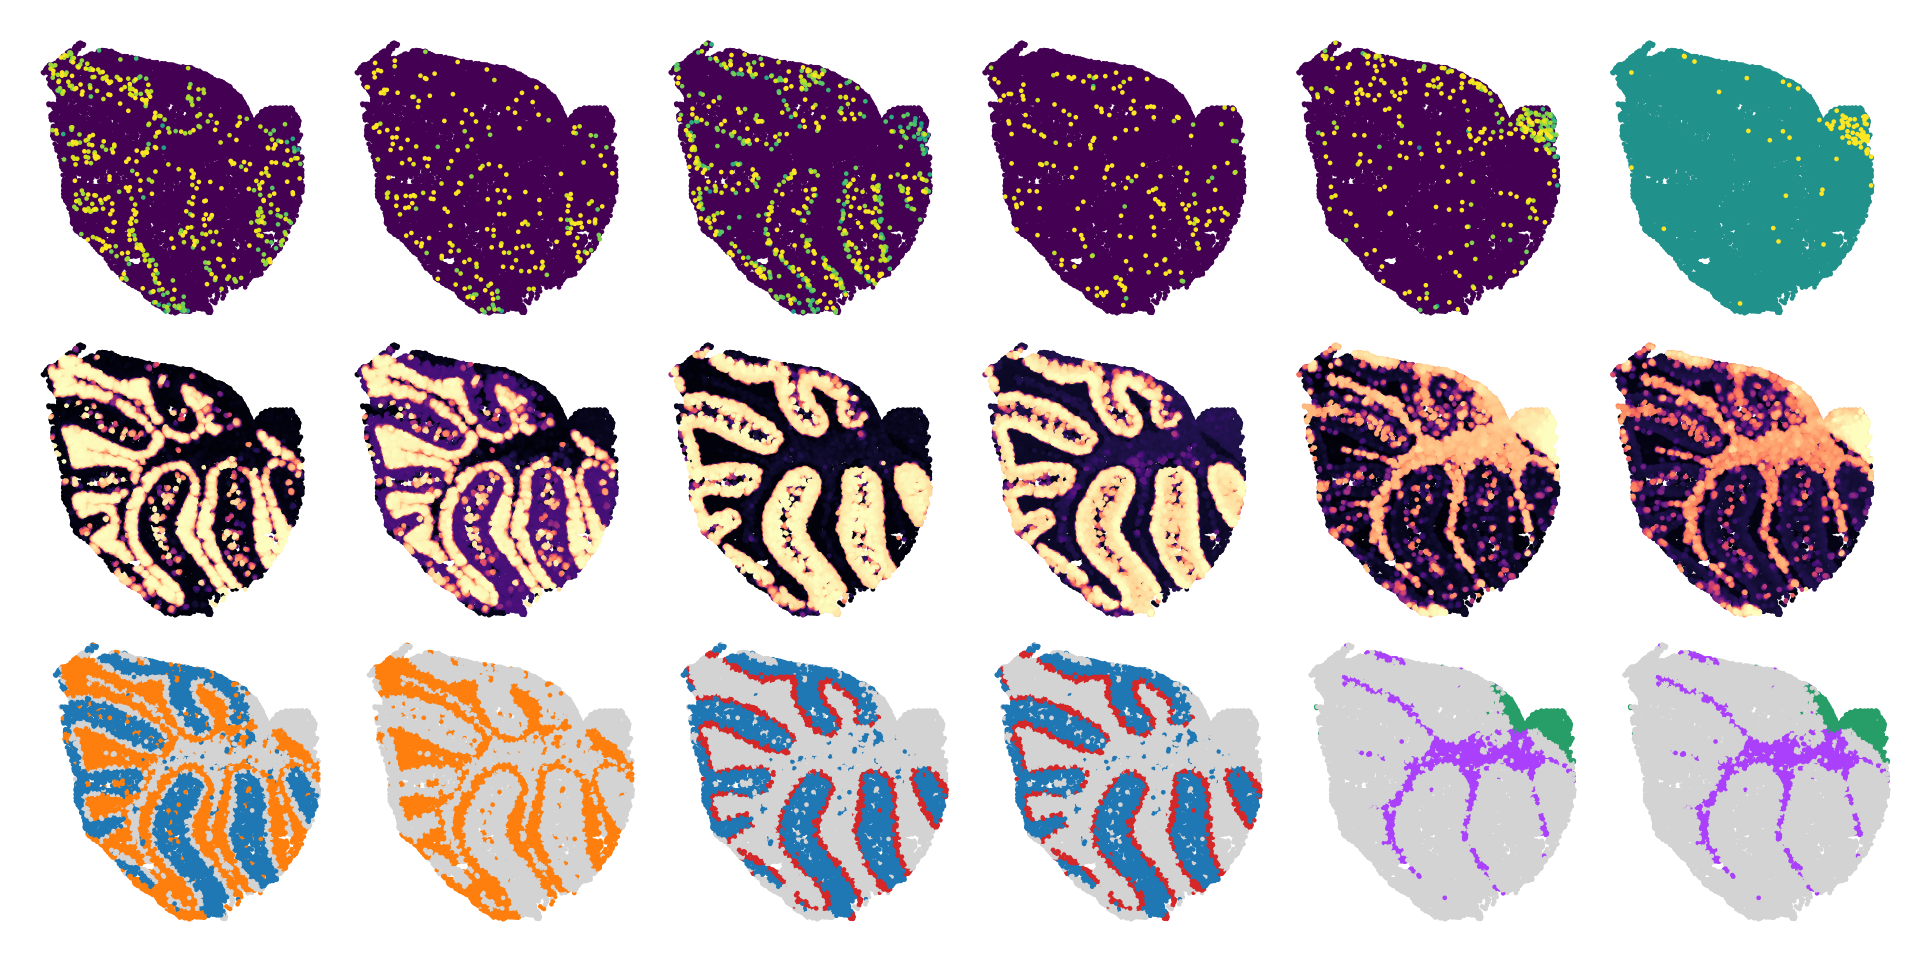

In [147]:
domain_palette = {str(ind): vega_20_scanpy[ind] for ind in range(n_class)}
plot_gene_indices = find_indices(ann_data, plot_gene_names)
fig, axs = plt.subplots(3, len(plot_gene_names), figsize=(len(plot_gene_names) * 1.35, 4))
for ind, gene_name in enumerate(plot_gene_names):
    temp_palette = {str(ind): "lightgrey" for ind in range(n_class)}
    indices_domain = np.where(stmarker_domains_df[stmarker_domains_df.index == gene_name].filter(regex="Spatial domain"))[1]
    ax = axs[2][ind]
    for ind_domain in indices_domain:
        temp_palette[str(ind_domain)] = domain_palette[str(ind_domain)]
    sc.pl.embedding(ann_data, basis="spatial", color="Consensus clustering", ax=ax, frameon=False, s=5, legend_loc=None, 
                    show=False, palette=temp_palette)
    ax.set_title("")
    ax.set_aspect("equal")
    ax = axs[1][ind]
    ann_data.obs["saliency"] = zsmap[:, plot_gene_indices[ind]]
    sc.pl.embedding(ann_data, basis="spatial", color="saliency", ax=ax, frameon=False, s=5, legend_loc=None, 
                    show=False, color_map="magma", vmin="p0.5", vmax="p99.5")
    ax.set_title("")
    ax.set_aspect("equal")
    ax = axs[0][ind]
    sc.pl.embedding(ann_data, basis="spatial", color=gene_name, ax=ax, frameon=False, s=5, legend_loc=None, 
                    show=False, color_map="viridis", vmin=0, vmax="p99.5")
    ax.set_title("")
    ax.set_aspect("equal")
remove_cbar(fig.axes)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(os.path.join(fig_dir, "maps_genes.png"), dpi=300)

# Gene enrichment analysis

In [29]:
import json
from scipy.stats import hypergeom
from venn import venn, pseudovenn
# Allen Brain atlas
with open("../../datasets/app5/mouse_cerebellum_gene_list_harmoni.json") as f:
    harmoniz_gene_list = json.load(f)
valid_gene_list = []
for d in harmoniz_gene_list["associations"]:
    if d["thresholdValue"] > 0:
        valid_gene_list.append(d["gene"]["symbol"])
valid_gene_list = (set(valid_gene_list).intersection(list(map(lambda x: x.upper(), ann_data.var.index.tolist()))))
print(len(valid_gene_list))

261


In [30]:
overlap_df = []
for key in genes_all:
    genes_list = genes_all[key]
    genes_list = set([gene.upper() for gene in genes_list])
    overlap_df.append([key, len(genes_list.intersection(valid_gene_list))])
overlap_df = pd.DataFrame(overlap_df)
overlap_df.columns = ["Method", "Overlap"]
overlap_df

Method  Overlap
0  STAMarker      108
1    HotSpot       80
2    SPARK-X       46
3  SpatialDE       28

STAMarker 5.294231690393716e-23
HotSpot 5.993242245048306e-09
SPARK-X 0.3858105011926456
SpatialDE 0.9983892653099933


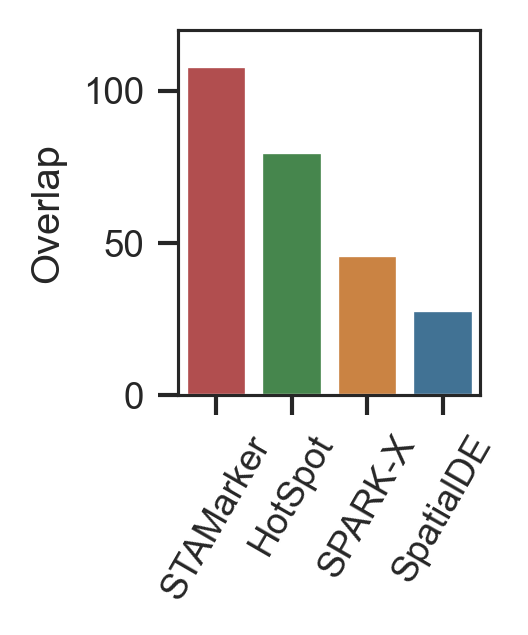

In [34]:
M = 3000
n = 261
N = len(genes_all["STAMarker"])
for method in overlap_df["Method"]:
    k = int(overlap_df[overlap_df.Method == method].Overlap)
    print(method, hypergeom.sf(k, M, n, N))
method_colors = {"STAMarker": "#C13E3F", "HotSpot": "#3B9144", "SPARK-X": "#E1822C", "SpatialDE": "#3375A2"}
fig, ax = plt.subplots(1, 1, figsize=(1.8, 2.25))
sns.barplot(data=overlap_df, x="Method", y="Overlap",palette=method_colors, ax=ax)
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)
# ax.set_ylabel("Overlap with reference")
ax.set_ylim([0, 120])
plt.tight_layout()
plt.savefig("figures/app5/barplot_overlap_allen_brain.png", dpi=300)

# Enrichmen analysis

In [ ]:
go_methods = {key: sc.queries.enrich(list(genes_all[key]), org="mmusculus") for key in genes_all}

In [377]:
go_domains = [sc.queries.enrich(list(genes), org="mmusculus") for genes in stmarker_svgs_list]

In [26]:
patterns = ["KEGG", "GO"]
for pattern in patterns:
    print("=" * 10, pattern, "=" * 10)
    for key in go_methods:
        df = go_methods[key]
        kegg = df[df["source"].str.contains(pattern)]
        print("-" * 10, key, kegg.shape, "-" * 10)
        # print(kegg.head(n=15)[["native", "name", "p_value"]])
        print("---" * 20)
        row = kegg[kegg.name.str.contains("cerebellum")][["native", "name", "p_value"]]
        if len(row) > 0:
            print(row)

========== KEGG ==========
---------- STAMarker (30, 14) ----------
------------------------------------------------------------
---------- HotSpot (24, 14) ----------
------------------------------------------------------------
---------- SPARK-X (32, 14) ----------
------------------------------------------------------------
---------- SpatialDE (0, 14) ----------
------------------------------------------------------------
========== GO ==========
---------- STAMarker (640, 14) ----------
------------------------------------------------------------
         native                      name   p_value
577  GO:0021549    cerebellum development  0.000359
592  GO:0021587  cerebellum morphogenesis  0.000483
---------- HotSpot (550, 14) ----------
------------------------------------------------------------
         native                      name   p_value
591  GO:0021587  cerebellum morphogenesis  0.005668
707  GO:0021549    cerebellum development  0.016012
---------- SPARK-X (578, 14) 

In [167]:
df = go_methods["STAMarker"]
df[df.name.str.contains("granule")]

source      native                name   p_value  significant  \
761  GO:CC  GO:0031045  dense core granule  0.004750         True   
919  GO:CC  GO:0048770     pigment granule  0.021137         True   
985  GO:CC  GO:0030141   secretory granule  0.035953         True   

                                           description  term_size  query_size  \
761  "Electron-dense organelle with a granular inte...         32         474   
919  "A small, subcellular membrane-bounded vesicle...        102         474   
985  "A small subcellular vesicle, surrounded by a ...        447         474   

     intersection_size  effective_domain_size  precision    recall    query  \
761                  6                  27317   0.012658  0.187500  query_1   
919                  9                  27317   0.018987  0.088235  query_1   
985                 20                  27317   0.042194  0.044743  query_1   

                      parents  
761              [GO:0030141]  
919              [GO:0031410]  
985  [GO:0012505, GO:0099503]

In [411]:
for ind, go in enumerate(go_domains):
    print("=" * 10, ind, "=" * 10)
    subset_go = go[go.name.str.contains("Pur")]
    print(subset_go[["name", "p_value"]])

========== 0 ==========
                                           name       p_value
146     parallel fiber to Purkinje cell synapse  4.667203e-07
342  cerebellar Purkinje cell layer development  1.056157e-03
========== 1 ==========
                                        name       p_value
165  parallel fiber to Purkinje cell synapse  4.393811e-07
========== 2 ==========
Empty DataFrame
Columns: [name, p_value]
Index: []
========== 3 ==========
                                             name   p_value
172       parallel fiber to Purkinje cell synapse  0.000359
180    cerebellar Purkinje cell layer development  0.000446
375  cerebellar Purkinje cell layer morphogenesis  0.039147
========== 4 ==========
Empty DataFrame
Columns: [name, p_value]
Index: []


In [480]:
for ind, go in enumerate(go_domains):
    print("=" * 10, ind, "=" * 10)
    subset_go = go[go.name.str.contains("fiber")]
    print(subset_go[["name", "p_value"]])

========== 0 ==========
                                                  name       p_value
146            parallel fiber to Purkinje cell synapse  4.667203e-07
175                               supramolecular fiber  4.025539e-06
209                  supramolecular fiber organization  2.308708e-05
210                       polymeric cytoskeletal fiber  2.396644e-05
390  negative regulation of supramolecular fiber or...  2.831001e-03
443    regulation of supramolecular fiber organization  6.142248e-03
========== 1 ==========
                                        name       p_value
165  parallel fiber to Purkinje cell synapse  4.393811e-07
550                     supramolecular fiber  2.011230e-02
========== 2 ==========
                             name   p_value
298  polymeric cytoskeletal fiber  0.018175
333          supramolecular fiber  0.034078
========== 3 ==========
                                        name   p_value
172  parallel fiber to Purkinje cell synapse  0.000359
22

In [444]:
go_domains_df

source      native                                               name  \
0    GO:CC  GO:0045202                                            synapse   
1    GO:CC  GO:0043005                                  neuron projection   
2    GO:CC  GO:0042995                                    cell projection   
3    GO:CC  GO:0120025            plasma membrane bounded cell projection   
4    GO:CC  GO:0030054                                      cell junction   
..     ...         ...                                                ...   
366     TF   TF:M00919                    Factor: E2F; motif: NCSCGCSAAAN   
367  GO:BP  GO:0043254  regulation of protein-containing complex assembly   
368  GO:BP  GO:0045687  positive regulation of glial cell differentiation   
369  GO:MF  GO:0008289                                      lipid binding   
370     TF   TF:M07436                   Factor: WT1; motif: NNGGGNGGGSGN   

          p_value  significant  \
0    1.155869e-38         True   
1    3.479343e-35         True   
2    2.206710e-34         True   
3    5.348544e-34         True   
4    1.942156e-33         True   
..            ...          ...   
366  4.476788e-02         True   
367  4.589663e-02         True   
368  4.870822e-02         True   
369  4.919866e-02         True   
370  4.976324e-02         True   

                                           description  term_size  query_size  \
0    "The junction between an axon of one neuron an...       1499         221   
1    "A prolongation or process extending from a ne...       1578         221   
2    "A prolongation or process extending from a ce...       2533         221   
3    "A prolongation or process extending from a ce...       2437         221   
4    "A cellular component that forms a specialized...       2117         221   
..                                                 ...        ...         ...   
366                    Factor: E2F; motif: NCSCGCSAAAN       5217         189   
367  "Any process that modulates the frequency, rat...        425         181   
368  "Any process that activates or increases the f...         54         181   
369                     "Binding to a lipid." [GOC:ai]        828         179   
370                   Factor: WT1; motif: NNGGGNGGGSGN       7746         189   

     intersection_size  effective_domain_size  precision    recall    query  \
0                   77                  27317   0.348416  0.051368  query_1   
1                   75                  27317   0.339367  0.047529  query_1   
2                   91                  27317   0.411765  0.035926  query_1   
3                   89                  27317   0.402715  0.036520  query_1   
4                   83                  27317   0.375566  0.039206  query_1   
..                 ...                    ...        ...       ...      ...   
366                 70                  21833   0.370370  0.013418  query_1   
367                 12                  27543   0.066298  0.028235  query_1   
368                  5                  27543   0.027624  0.092593  query_1   
369                 17                  25412   0.094972  0.020531  query_1   
370                 94                  21833   0.497354  0.012135  query_1   

                                  parents  Spatial domain  
0                            [GO:0030054]               0  
1                            [GO:0120025]               0  
2                            [GO:0110165]               0  
3                            [GO:0042995]               0  
4                            [GO:0110165]               0  
..                                    ...             ...  
366                           [TF:M00000]               4  
367  [GO:0044087, GO:0051128, GO:0065003]               4  
368  [GO:0010001, GO:0014015, GO:0045685]               4  
369                          [GO:0005488]               4  
370                           [TF:M00000]               4  

[2394 rows x 15 columns]

In [464]:
go_domains_df = []
for ind, go in enumerate(go_domains):
    go = copy.copy(go)
    go["Spatial domain"] = str(ind)
    go["-logp"] = - np.log(go["p_value"])
    go_domains_df.append(go)
go_domains_df = pd.concat(go_domains_df)
go_domains_df = go_domains_df[go_domains_df.source.str.contains("GO")]


In [500]:
spatial_domain_names = {0: "MOL", 3: "PL", 1: "GCL", 4: "WM", 2: "CN"}
go_domains_df["Spatial domain names"] = go_domains_df["Spatial domain"].apply(lambda x: 
                                                                              spatial_domain_names[int(x)])

In [519]:
def get_selected_go_terms(patterns, go_domains_df):
    selected_go_natives = []
    selected_go_names = []
    for pattern in patterns:
        selected_go_natives += go_domains_df[go_domains_df.name.str.contains(pattern)].native.tolist()
        selected_go_names += go_domains_df[go_domains_df.name.str.contains(pattern)].name.tolist()
    return selected_go_natives, selected_go_names

In [579]:
native_domain_df = go_domains_df.pivot_table(index="native", columns="Spatial domain", values="-logp", fill_value=0)
native_domain_df["cv"] = np.var(native_domain_df, axis=1) / np.mean(native_domain_df, axis=1)
native_domain_df.sort_values(by="cv", ascending=False)

Spatial domain          0          1          2          3          4  \
native                                                                  
GO:0005654       0.000000  31.176642   0.000000   0.000000   0.000000   
GO:0046872       0.000000  21.585254   0.000000   0.000000   0.000000   
GO:0043169       0.000000  21.426539   0.000000   0.000000   0.000000   
GO:0006325       0.000000  21.113699   0.000000   0.000000   0.000000   
GO:0043209      40.448819   0.000000  54.530558  14.036939  53.758042   
...                   ...        ...        ...        ...        ...   
GO:0032879      18.993047  17.266762  12.291835   8.867225  13.402720   
GO:0031344      21.327906  13.122687  16.581121  10.773754  17.323350   
GO:0120035      21.894092  13.573992  15.139233  11.169796  15.973122   
GO:0012505      14.581165   8.627643  14.027325   9.501383  15.130217   
GO:0110165      18.668437  16.688873  13.133055  13.017941  17.064225   

Spatial domain         cv  
native                     
GO:0005654      24.941314  
GO:0046872      17.268203  
GO:0043169      17.141231  
GO:0006325      16.890959  
GO:0043209      14.729305  
...                   ...  
GO:0032879       0.919031  
GO:0031344       0.833026  
GO:0120035       0.819111  
GO:0012505       0.605953  
GO:0110165       0.323678  

[729 rows x 6 columns]

In [609]:
selected_go_natives, selected_go_names = get_selected_go_terms(["Pur", "GABA", "myelination", "gran"], 
                                                               go_domains_df)
native_name_dict = {}
for native, name in zip(selected_go_natives, selected_go_names):
    native_name_dict[native] = name
selected_go_natives = np.unique(selected_go_natives)

{'GO:0098688': 'parallel fiber to Purkinje cell synapse',
 'GO:0021680': 'cerebellar Purkinje cell layer development',
 'GO:0021692': 'cerebellar Purkinje cell layer morphogenesis',
 'GO:0098982': 'GABA-ergic synapse',
 'GO:0042552': 'myelination',
 'GO:0022010': 'central nervous system myelination',
 'GO:0048770': 'pigment granule',
 'GO:0031045': 'dense core granule',
 'GO:0030141': 'secretory granule',
 'GO:0042583': 'chromaffin granule'}

In [612]:
selected_go_domains_df = go_domains_df[np.isin(go_domains_df.native, selected_go_natives)]
selected_go_domains_df["Spatial domain names"] = pd.Categorical(selected_go_domains_df["Spatial domain names"],
                                                               ["MOL", "PL", "GCL", "WM", "CN"],)
selected_go_domains_df["native"] = pd.Categorical(selected_go_domains_df["native"], 
                                                                native_name_dict.keys())
selected_go_domains_df.sort_values(by=["Spatial domain names", "native"], inplace=True)

In [627]:
native_name_dict

{'GO:0098688': 'parallel fiber to Purkinje cell synapse',
 'GO:0021680': 'cerebellar Purkinje cell layer development',
 'GO:0021692': 'cerebellar Purkinje cell layer morphogenesis',
 'GO:0098982': 'GABA-ergic synapse',
 'GO:0042552': 'myelination',
 'GO:0022010': 'central nervous system myelination',
 'GO:0048770': 'pigment granule',
 'GO:0031045': 'dense core granule',
 'GO:0030141': 'secretory granule',
 'GO:0042583': 'chromaffin granule'}

In [632]:
sns.set_style("ticks",{'axes.grid' : True})
fig, ax = plt.subplots(1, 1, figsize=(4.75, 2.45))
sns.scatterplot(data=selected_go_domains_df, x="native", y="Spatial domain names", 
                size="intersection_size", legend="brief", hue="-logp", 
                ax=ax, palette="viridis")
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
# ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
ax.set_ylabel("")
ax.set_xlabel("")
plt.xticks(rotation=45)
plt.tight_layout()